In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import numpy as np
import pandas as pd
import shap
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

In [3]:
# Load dataset
df = pd.read_csv("/content/drive/MyDrive/project/data/survival_dataset.csv")

# Features only (drop time/event)
feature_names = [c for c in df.columns if c not in ['time','event']]
X_raw = df[feature_names].values.astype('float32')

# Impute missing values
imputer = SimpleImputer(strategy='mean')
X_imp = imputer.fit_transform(X_raw)

# Scale features (same as training)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_imp).astype('float32')

In [6]:
# Risk function: log hazard ratio from trained DeepSurv model
def risk_fn(x):
    x = np.asarray(x, dtype='float32')
    out = model.predict(x)  # DeepSurv linear predictor
    out = np.array(out).reshape(-1)
    if not np.isfinite(out).all():
        finite = out[np.isfinite(out)]
        med = np.median(finite) if finite.size > 0 else 0.0
        out = np.where(np.isfinite(out), out, med)
    return out

In [16]:
!pip install pycox torchtuples --quiet
!pip install torch --quiet

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.6/73.6 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.9/41.9 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.7/69.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.0/97.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.7/51.7 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 142.7/142.7 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 429.9/429.9 kB 17.3 MB/s eta 0:00:00


In [17]:
from pycox.models import CoxPH
import torchtuples as tt
import torch

# Define the same network architecture used in training
in_features = X_scaled.shape[1]
net = tt.practical.MLPVanilla(in_features, [64, 32], 1, batch_norm=True, dropout=0.1)

# Recreate CoxPH model
model = CoxPH(net, torch.optim.Adam)
model.optimizer.set_lr(1e-3)

# Load trained weights
model.load_model_weights("/content/drive/MyDrive/project/deepsurv_model.pt")

  0%|          | 0/10 [00:00<?, ?it/s]

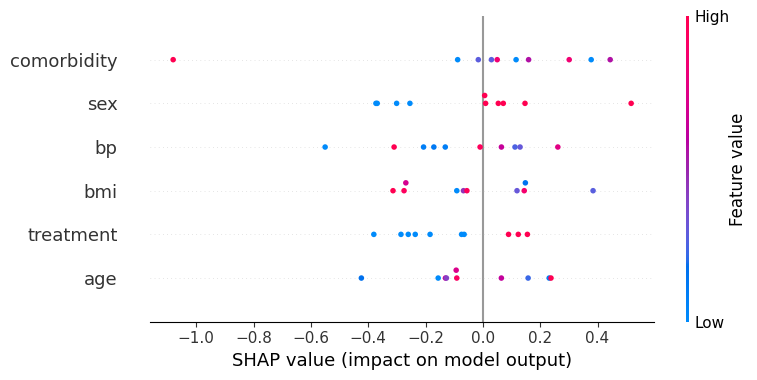

In [18]:
# Background and sample sets
background = X_scaled[:50]
sample = X_scaled[:10]

# KernelExplainer
explainer = shap.KernelExplainer(risk_fn, background)

# Compute SHAP values
shap_values = explainer.shap_values(sample, nsamples=100)

# Convert to array
shap_arr = np.asarray(shap_values, dtype='float32')
if shap_arr.ndim == 1:
    shap_arr = shap_arr.reshape(1, -1)

# Global summary plot
shap.summary_plot(shap_arr, sample, feature_names=feature_names)

Low-risk patients: [[0]
 [0]
 [0]]
High-risk patients: [[0]
 [0]
 [0]]


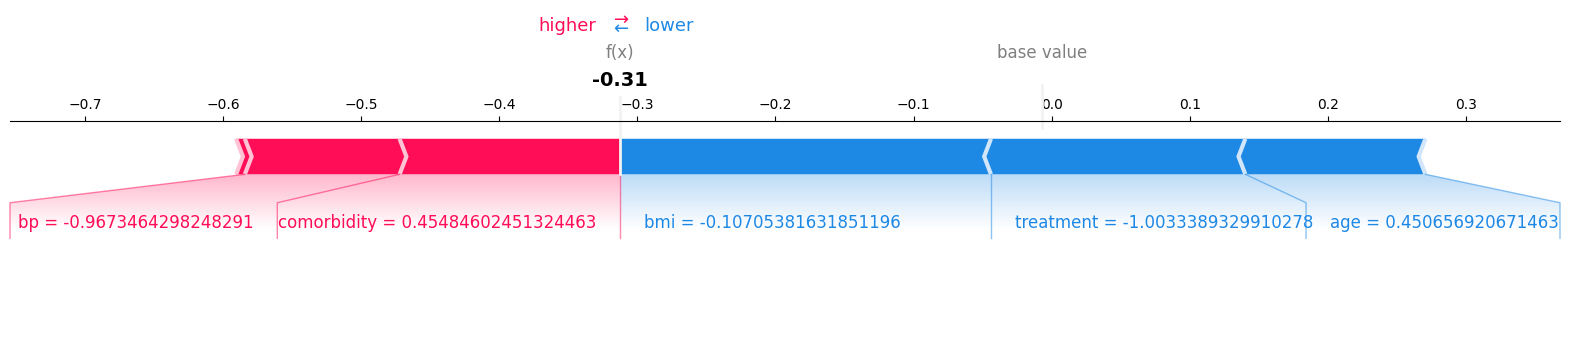

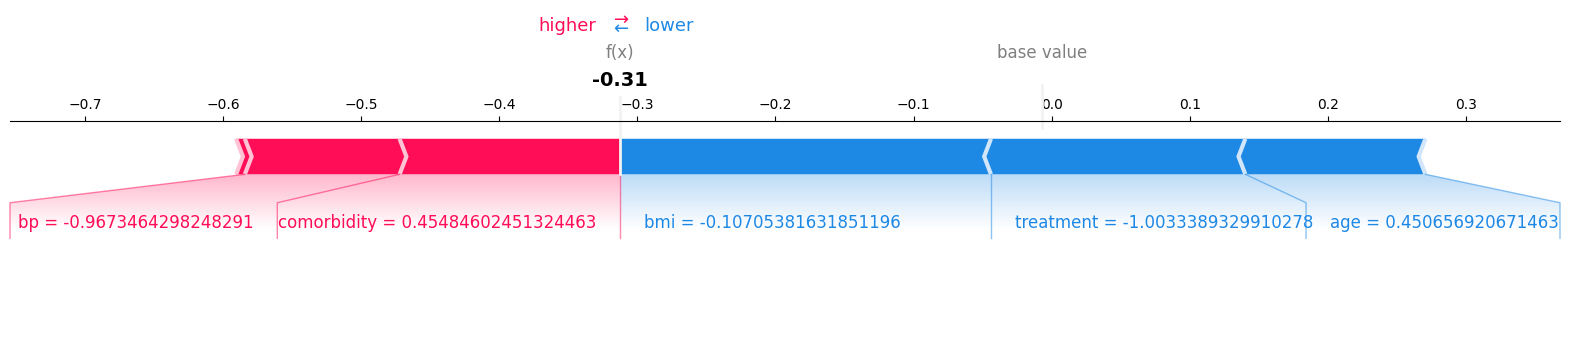

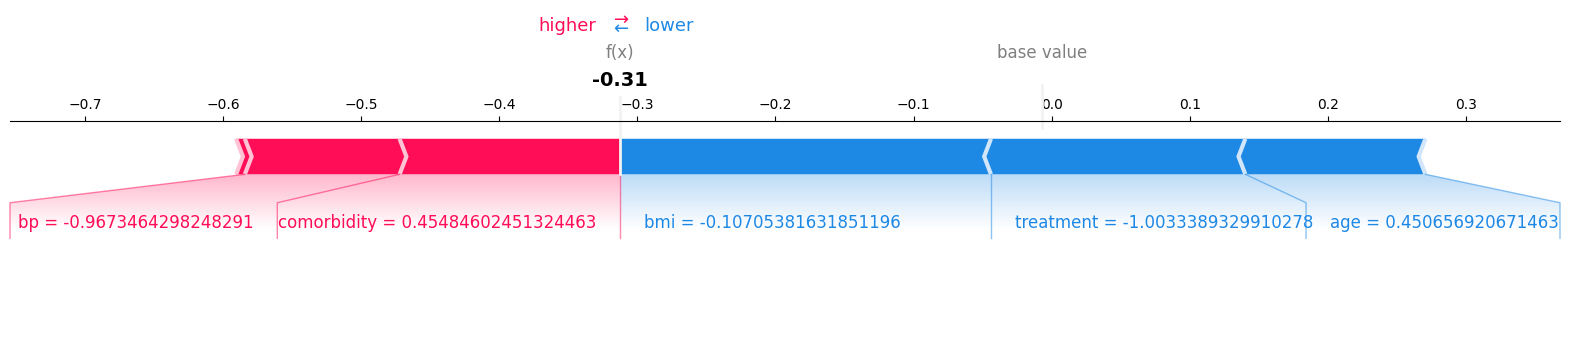

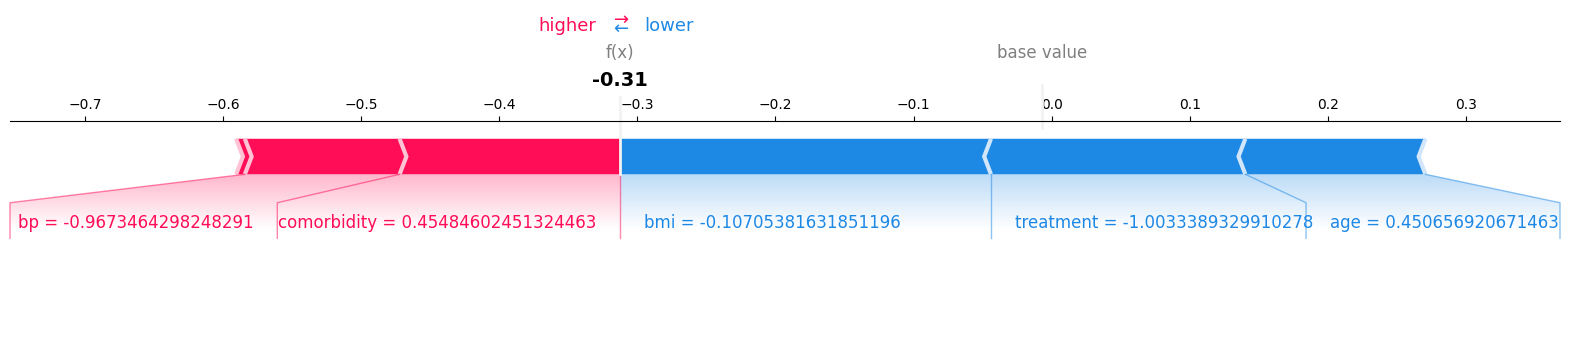

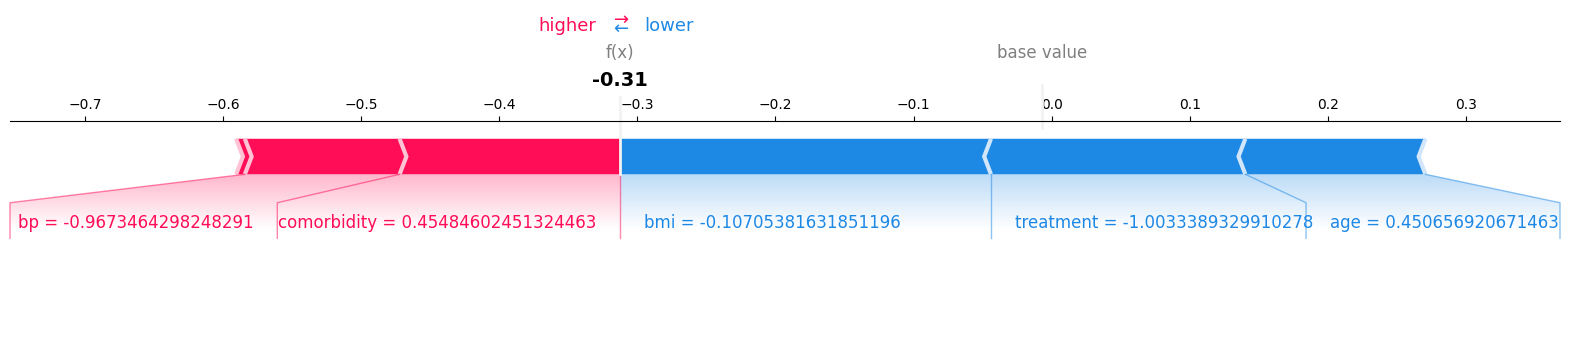

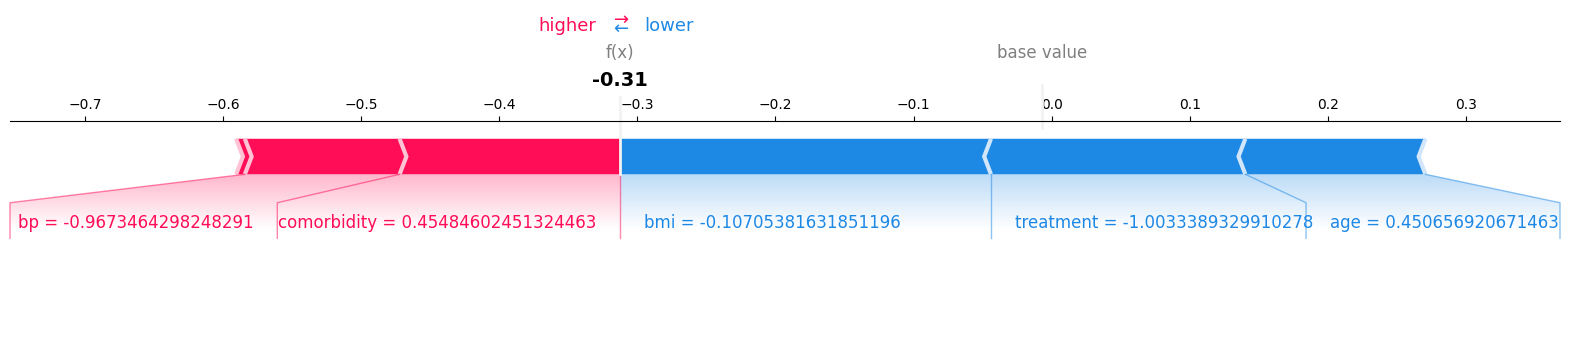

In [19]:
# ============================================
# Cell 5 — Local SHAP Force Plots
# ============================================

# 1) Compute risk scores for all patients
risk_scores = model.predict(X_scaled)

# 2) Sort patients by risk
sorted_idx = np.argsort(risk_scores)

# 3) Select 3 low-risk and 3 high-risk patients
low_risk_idx = sorted_idx[:3]
high_risk_idx = sorted_idx[-3:]

# 4) Generate force plots
print("Low-risk patients:", low_risk_idx)
print("High-risk patients:", high_risk_idx)

for idx in low_risk_idx:
    shap.force_plot(
        explainer.expected_value,
        shap_arr[idx],
        X_scaled[idx],
        feature_names=feature_names,
        matplotlib=True
    )

for idx in high_risk_idx:
    shap.force_plot(
        explainer.expected_value,
        shap_arr[idx],
        X_scaled[idx],
        feature_names=feature_names,
        matplotlib=True
    )

       Feature  CoxPH_Coefficient  MeanAbs_SHAP
4  comorbidity          -0.125611      0.266271
1          sex          -0.024635      0.210194
3           bp           0.013893      0.194679
2          bmi           0.037098      0.186749
5    treatment           0.131358      0.185426
0          age          -0.134726      0.171274


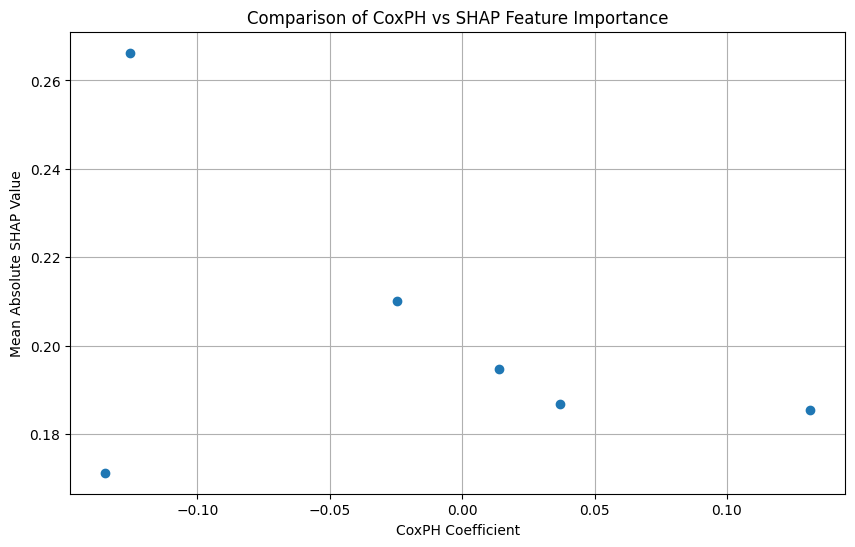

In [21]:
# ============================================
# Cell 6 — Compare SHAP Importance with CoxPH Coefficients (fixed)
# ============================================
import torch
import torch.nn as nn
from pycox.models import CoxPH

# 1) Define a simple linear network for CoxPH
in_features = X_scaled.shape[1]
net_cox = nn.Sequential(nn.Linear(in_features, 1))  # plain linear layer

# 2) Fit CoxPH model
cox_model = CoxPH(net_cox, torch.optim.Adam)
cox_model.optimizer.set_lr(1e-3)

cox_model.fit(
    X_scaled,
    (df['time'].values.astype('float32'), df['event'].values.astype('int32')),
    batch_size=32,
    epochs=50,
    verbose=False
)

# 3) Extract CoxPH coefficients
weights = net_cox[0].weight.detach().numpy().flatten()

# 4) Compute mean absolute SHAP values (global importance)
shap_importance = np.abs(shap_arr).mean(axis=0)

# 5) Compare rankings
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'CoxPH_Coefficient': weights,
    'MeanAbs_SHAP': shap_importance
}).sort_values('MeanAbs_SHAP', ascending=False)

print(importance_df.head(10))  # top 10 features

# 6) Plot comparison
plt.figure(figsize=(10,6))
plt.scatter(importance_df['CoxPH_Coefficient'], importance_df['MeanAbs_SHAP'])
plt.xlabel("CoxPH Coefficient")
plt.ylabel("Mean Absolute SHAP Value")
plt.title("Comparison of CoxPH vs SHAP Feature Importance")
plt.grid(True)
plt.show()

In [24]:
# ============================================
# Cell 7 — Save SHAP & Survival Analysis Outputs
# ============================================

# Save importance comparison table
importance_df.to_csv("/content/drive/MyDrive/project/results/shap_vs_coxph.csv", index=False)

# Save comparison scatter plot
plt.figure(figsize=(10,6))
plt.scatter(importance_df['CoxPH_Coefficient'], importance_df['MeanAbs_SHAP'])
plt.xlabel("CoxPH Coefficient")
plt.ylabel("Mean Absolute SHAP Value")
plt.title("Comparison of CoxPH vs SHAP Feature Importance")
plt.grid(True)
plt.savefig("/content/drive/MyDrive/project/results/shap_vs_coxph.png")
plt.close()

print("✅ Results saved into existing 'results' folder")

✅ Results saved into existing 'results' folder
